# Financial Prediction using Machine Learning Part II: Logistic Regression

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# Import Libaries
import workshop_library as wl
from workshop_library.training import training
from workshop_library import financial_backtest
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 8.0)
fontsize=20
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

In [6]:
# load the financial time series data
df = pd.read_csv('financial_data.csv')

### Set the Model and Training parameters

In [9]:
backtest_settings = {
    'backtest_method': 'walk_forward_rolling',#'simple_split', #walk_forward_rolling, walk_forward_extending
    'training_window': 1000, #number of days that are used for the training in a rolling or extending procedure
    'step_size': 10, #number of days the training frame is shifted forward in each iteration
    'test_train_diff_days': 1 #time gap between training and test
}

model = LogisticRegression() #as an alternative, try Ridge()
target = 'direction_target' #as an alternative, try 'ret_10d
risk_free_interest = .02 #
is_regr_class= 'class'

In [10]:
# Exectue the model training
result = training(
        df=df,
        model=model,
        backtest_settings=backtest_settings,
        date_column='Date',
        target=target,
        hide_columns=['ret_10d', 'target', 'ret_1d', 'ret_20d', 'direction_target']
    )

### Evaluate the correctness of linear regression results

In [11]:
# Note: The classical metrics such as Rsquared cannot be used in a straightforward fashion because they are defined in-sample

In [12]:
# Calculate the directional_correctness
direction_correct_ratio = ((result['prediction'] > 0) == (result['truth'] > 0)).mean()
print('Directional Correctness: %1.1f %%' % ( direction_correct_ratio* 100))

Directional Correctness: 50.5 %


In [13]:
# Calculate the median absolute deviation
median_absolute_deviation = (result['prediction'] - result['truth']).abs().median()
print('Median Absolute Deviation: %1.3f' % ( median_absolute_deviation* 100))

Median Absolute Deviation: 0.000


### Run a financial backtest with the trained model

Sharpe Ratio: 0.53
Annual Return: 0.09


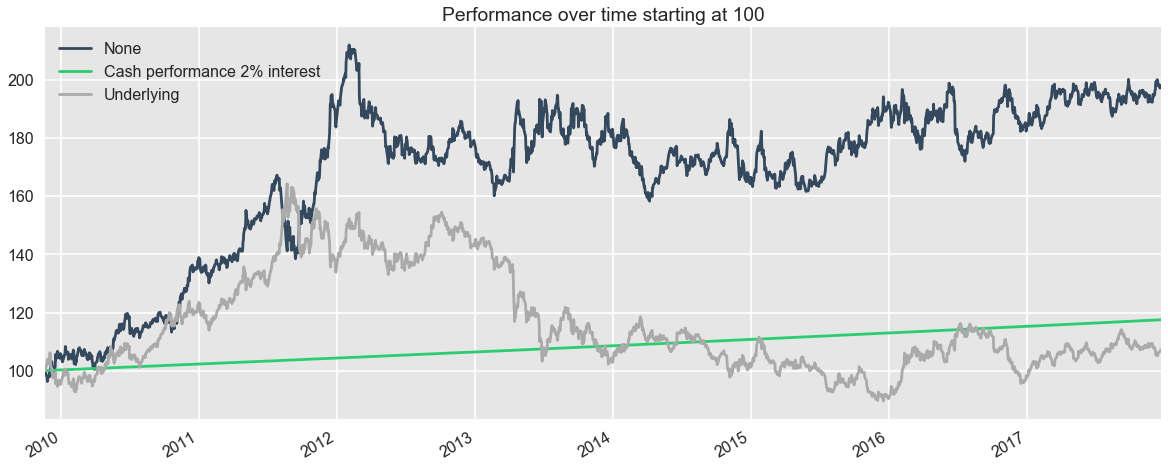

In [25]:
# Run a financial backtest
fb = financial_backtest.SimpleBacktest(prediction_series=result['prediction'], underlying_series=df['close'], is_regr_class= is_regr_class)
ax = fb.performance.plot(title = 'Performance over time starting at 100');
ax.plot(fb.performance.index, 100*np.cumprod(pd.Series([np.power(1+risk_free_interest, 1/250)] * fb.performance.shape[0])), label = 'Cash performance 2% interest')
ax.plot(fb.performance.index, pd.Series(1+df.loc[result.index].close.pct_change().fillna(0)).cumprod()*100, color = '#AAAAAA', label = 'Underlying')
ax.legend()
print('Sharpe Ratio: %1.2f' % fb.sharpe_ratio)
print('Annual Return: %1.2f' % fb.return_per_annum)